## Импорт необходимых библиотек ##

In [145]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Предварительное знакомство с данными.


In [146]:
hotels = pd.read_csv("C:\Data_sets\hotels (1).csv")

Проверим данные на пропуски

In [199]:
hotels.isna().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

Пропуски в коррдинатах широты и долготы. Я пыталась заполнять геопай, но не получается, он просто не находит координаты.

In [27]:
from geopy.geocoders import Nominatim
import time

def get_coordinates(address):
    geolocator = Nominatim(user_agent="myGeocoderApp")
    
    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None  # Адрес не найден
    except Exception as e:
        print(f"Ошибка: {e}")
        return None, None  # Возврат None в случае ошибки

address = "4 rue de la P pini re 8th arr 75008 Paris France"
coords = get_coordinates(address)

if coords:
    print(f"Координаты для адреса '{address}': Широта: {coords[0]}, Долгота: {coords[1]}")
else:
    print(f"Координаты для адреса '{address}' не найдены.")


Координаты для адреса '4 rue de la P pini re 8th arr 75008 Paris France': Широта: None, Долгота: None


Не смогла разобраться, как искать. Не находит у меня он эти адреса. Даже при ручной подстановке адреса.

Подставим из готового славаря.

In [147]:
hotel_adress = hotels[(hotels.lng.isna()) & (hotels.lat.isna())].groupby(by = ['hotel_address','hotel_name']).count().iloc[:,0]
hotel_adress

hotel_address                                                hotel_name                                      
20 Rue De La Ga t 14th arr 75014 Paris France                Mercure Paris Gare Montparnasse                      28
23 Rue Damr mont 18th arr 75018 Paris France                 Holiday Inn Paris Montmartre                         47
4 rue de la P pini re 8th arr 75008 Paris France             Maison Albar Hotel Paris Op ra Diamond              224
Bail n 4 6 Eixample 08010 Barcelona Spain                    NH Collection Barcelona Podium                      113
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria          City Hotel Deutschmeister                            63
Hasenauerstra e 12 19 D bling 1190 Vienna Austria            Hotel Park Villa                                     44
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria  Fleming s Selection Hotel Wien City                 496
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria     Cordial Th

In [148]:
hot_na_coor = {
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

In [149]:
def fill_coordinates(row):
    hotel_name = row['hotel_name']
    if hotel_name in hot_na_coor:
        return pd.Series(hot_na_coor[hotel_name])
    else:
        return pd.Series([row['lat'], row['lng']])
hotels[['lat', 'lng']] = hotels.apply(fill_coordinates, axis=1)

In [221]:
hotels.isna().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
dtype: int64

In [191]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

**Нулей в датасете больше нет.**

## Создание новых призаков ##

**1.Выделение города из адреса обьекта**

In [90]:
hotels.hotel_address.isna().sum()

0

In [150]:
hotels['hotel_country'] = hotels['hotel_address'].map(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))
hotels['hotel_country'].value_counts(normalize=True)

hotel_country
United Kingdom    0.508719
Spain             0.116680
France            0.115899
Netherlands       0.111183
Austria           0.075434
Italy             0.072086
Name: proportion, dtype: float64

**3.Анализ тегов и выделение новых признаков из них.**

Из тегов можно забрать информацию о типе поездки и количестве ночей. Сделаем это.

Относительно количества уникальных тегов и выделения информации по ним.

In [151]:
unique_values = set()
def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels['tags_n'] = hotels['tags'].apply(rev_func)
for row in hotels['tags_n']:
  for value in row:
    unique_values.add(value)
a =len(unique_values)

tag_counts = hotels['tags_n'].explode().value_counts()

# Находим тег с максимальным количеством
most_frequent_tag = tag_counts.idxmax()
most_frequent_count = tag_counts.max()

# Выводим результаты
print(f'Количество уникальных тегов {a}')
print(f"Тег, представленный в наибольшем числе отзывов: {most_frequent_tag}")
print(f"Количество отзывов с этим тегом: {most_frequent_count}")


Количество уникальных тегов 2368
Тег, представленный в наибольшем числе отзывов: Leisure trip
Количество отзывов с этим тегом: 313593


Выделяем признак - количество ночей.

In [152]:
def nights(tags):
  for value in tags:
    words = str(value).split(' ')
    for word in words:
      try:
        nights = int(word)
        if 1 <= nights <= 100:
          return nights
      except ValueError:
        pass
  return None # Возвращаем None, если количество ночей не найдено

hotels['nights'] = hotels['tags_n'].map(nights)
hotels['nights'] = hotels['nights'].fillna(0)
most_frequent_night = hotels['nights'].explode().value_counts().idxmax()
print(f"Чаще всего путешественники останавливаются на: {most_frequent_night} ночь")

Чаще всего путешественники ост анавливаются на: 1.0 ночь


In [322]:
hotels['nights'].isna().sum()

0

Следующий признак. Тип поездки.

In [153]:
def get_trip(arg):
    for tag in arg:
        if 'trip' in tag:
            return tag.split()[0]
        
hotels['trip_type'] = hotels['tags_n'].map(get_trip)
hotels['trip_type'].describe()
hotels['trip_type'] = hotels['trip_type'].fillna(0)
hotels['trip_type'].isna().sum()

0

**3. Признак национальности**

In [154]:
hotels['reviewer_nationality'].value_counts(normalize=True)

reviewer_nationality
United Kingdom               0.475780
United States of America     0.068616
Australia                    0.041983
Ireland                      0.028764
United Arab Emirates         0.019692
                               ...   
Cook Islands                 0.000003
Guinea                       0.000003
Comoros                      0.000003
Anguilla                     0.000003
Grenada                      0.000003
Name: proportion, Length: 225, dtype: float64

In [246]:
hotels['reviewer_nationality']

0                United Kingdom 
1                United Kingdom 
2                         China 
3                United Kingdom 
4                        Poland 
                   ...          
386798                   France 
386799                   Turkey 
386800              Netherlands 
386801     United Arab Emirates 
386802                Australia 
Name: reviewer_nationality, Length: 386803, dtype: object

Создадим новый признак национальности - топ 10 и остальные. Так как остальные меньше процента.

In [155]:


top_5 = hotels['reviewer_nationality'].value_counts().nlargest(10).index
hotels['nationality_grouped'] = hotels['reviewer_nationality'].map(lambda x: x if x in top_5 else 'other')

In [193]:
hotels['nationality_grouped']

0                United Kingdom 
1                United Kingdom 
2                          other
3                United Kingdom 
4                          other
                   ...          
386798                     other
386799                     other
386800              Netherlands 
386801     United Arab Emirates 
386802                Australia 
Name: nationality_grouped, Length: 386803, dtype: object

In [97]:
hotels['nationality_grouped']

0                United Kingdom 
1                United Kingdom 
2                          other
3                United Kingdom 
4                          other
                   ...          
386798                     other
386799                     other
386800              Netherlands 
386801     United Arab Emirates 
386802                Australia 
Name: nationality_grouped, Length: 386803, dtype: object

In [98]:
hotels['nationality_grouped'].value_counts()

nationality_grouped
 United Kingdom               184033
other                         109479
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
 Saudi Arabia                   6722
 Netherlands                    6608
 Switzerland                    6498
 Canada                         5984
 Germany                        5956
Name: count, dtype: int64

**4.Признак даты**

In [156]:
hotels['review_date']=pd.to_datetime(hotels['review_date'],errors='coerce')
min_time = hotels['review_date'].dt.strftime('%Y-%m-%d').min()
max_time = hotels['review_date'].dt.strftime('%Y-%m-%d').max()
print(f'Самый ранний отзыв {min_time} , a самый поздний отзыв {max_time}')

Самый ранний отзыв 2015-08-04 , a самый поздний отзыв 2017-08-03


Выделим год, день, месяц.

In [157]:
hotels['year'] = pd.to_datetime(hotels['review_date']).dt.year
hotels['month'] = pd.to_datetime(hotels['review_date']).dt.month
hotels['day'] = pd.to_datetime(hotels['review_date']).dt.day

In [231]:
hotels.isna().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
hotel_country                                 0
tags_n                                        0
nights                                        0
trip_type                               

 **Новые признаки созданы. Двигаемся дальше.**

## Числовые признаки ##

## Кодирование категориальных признаков ##

In [101]:
hotels['trip_type'].value_counts()

trip_type
Leisure     313593
Business     61989
0            11221
Name: count, dtype: int64

In [16]:
hotels = pd.get_dummies(hotels, columns=['trip_type'])

In [158]:
hotels = pd.get_dummies(hotels, columns=['hotel_country'])

**Кодировка национальности** 

In [159]:
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['nationality_grouped']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['nationality_grouped'])
hotels = pd.concat([hotels, type_bin], axis=1)


In [64]:
hotels['nationality_grouped']

0                United Kingdom 
1                United Kingdom 
2                          other
3                United Kingdom 
4                          other
                   ...          
386798                     other
386799                     other
386800              Netherlands 
386801     United Arab Emirates 
386802                Australia 
Name: nationality_grouped, Length: 386803, dtype: object

**Кодирование признака ночей** 

In [263]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

## Анализ текстовых отзывов ##

Проведем анализ текстовых отзывов при помощи библиотеки Сантиментайзер.

In [160]:
#!pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer


sent_analyzer = SentimentIntensityAnalyzer()

hotels['neg_scores'] = hotels['negative_review'].map(sent_analyzer.polarity_scores)
hotels['pos_scores'] = hotels['positive_review'].map(sent_analyzer.polarity_scores)

hotels['n_review_sentiments_neg'] = hotels['neg_scores'].map(lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['neg_scores'].map(lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['neg_scores'].map(lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['neg_scores'].map(lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['pos_scores'].map(lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['pos_scores'].map(lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['pos_scores'].map(lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['pos_scores'].map(lambda x: x['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Анализ мультиколлинеарности ##

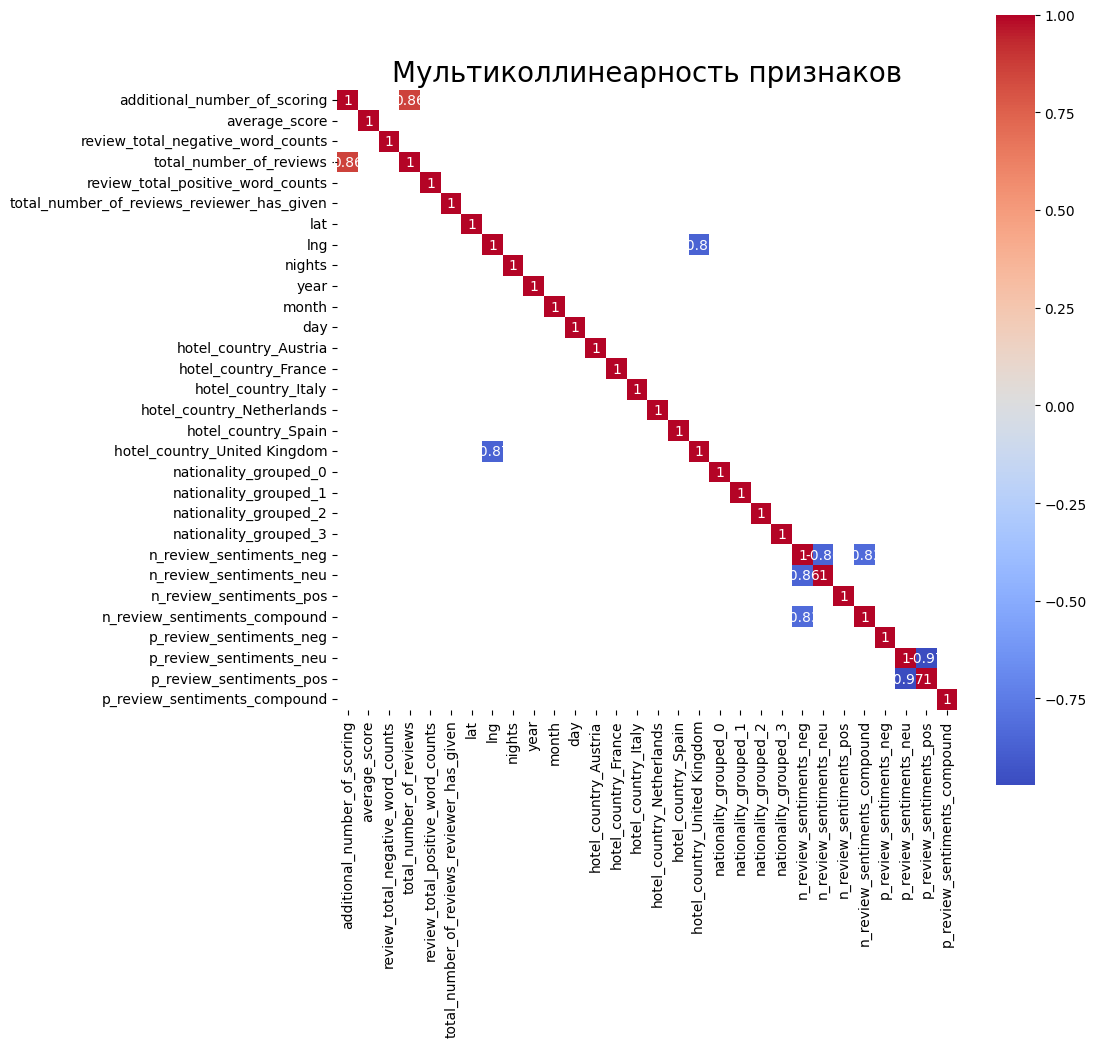

In [161]:
corr = hotels.drop(['reviewer_score'], axis=1).corr( numeric_only = True, method='spearman')
plt.subplots(figsize=(10, 10))

# выведем только сильную
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.80],         cmap='coolwarm',     square=True,
    annot = True
)


ax_heat_multicoll.set_title('Мультиколлинеарность признаков', fontsize=20);

Удаление столбцов с учетом мультиколлинеарности в том числе будет производиться в конце. Из данной карты видно, что связь между 'total_number_of reviews' и additional_number_of_scoring велика , но по итогу я не удалила один из них, потому что ухудшалось значение MAP. Есть корреляция между координатами и страной отеля, что естественно. Один из этих признаков будет удален. 

## 6. Отбор признаков на основе их важности ##

Проведем тест ANOVA

In [162]:
hotels.columns.to_list()

['hotel_address',
 'additional_number_of_scoring',
 'review_date',
 'average_score',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'positive_review',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'tags',
 'days_since_review',
 'lat',
 'lng',
 'tags_n',
 'nights',
 'trip_type',
 'nationality_grouped',
 'year',
 'month',
 'day',
 'hotel_country_Austria',
 'hotel_country_France',
 'hotel_country_Italy',
 'hotel_country_Netherlands',
 'hotel_country_Spain',
 'hotel_country_United Kingdom',
 'nationality_grouped_0',
 'nationality_grouped_1',
 'nationality_grouped_2',
 'nationality_grouped_3',
 'neg_scores',
 'pos_scores',
 'n_review_sentiments_neg',
 'n_review_sentiments_neu',
 'n_review_sentiments_pos',
 'n_review_sentiments_compound',
 'p_review_sentiments_neg',
 'p_review_sentiments_neu',
 'p_review_sentiments_pos',
 'p_review_sentiments_compound']

In [171]:
cat_cols = ['average_score', 'lat','nights','year','month','day']

<Axes: >

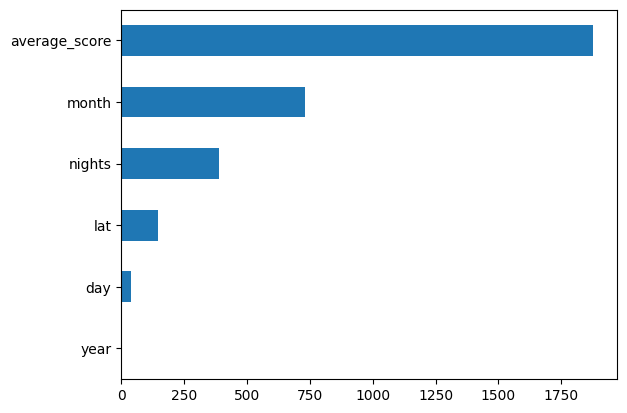

In [200]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [197]:
hotels['days_since_review']

0         531
1         203
2         289
3         681
4         516
         ... 
386798    106
386799    171
386800    543
386801     74
386802    363
Name: days_since_review, Length: 386803, dtype: int32

In [218]:
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts','average_score','total_number_of_reviews_reviewer_has_given','additional_number_of_scoring','review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given','lng','lat']

In [175]:
hotels.columns.to_list()

['hotel_address',
 'additional_number_of_scoring',
 'review_date',
 'average_score',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'positive_review',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'tags',
 'days_since_review',
 'lat',
 'lng',
 'tags_n',
 'nights',
 'trip_type',
 'nationality_grouped',
 'year',
 'month',
 'day',
 'hotel_country_Austria',
 'hotel_country_France',
 'hotel_country_Italy',
 'hotel_country_Netherlands',
 'hotel_country_Spain',
 'hotel_country_United Kingdom',
 'nationality_grouped_0',
 'nationality_grouped_1',
 'nationality_grouped_2',
 'nationality_grouped_3',
 'neg_scores',
 'pos_scores',
 'n_review_sentiments_neg',
 'n_review_sentiments_neu',
 'n_review_sentiments_pos',
 'n_review_sentiments_compound',
 'p_review_sentiments_neg',
 'p_review_sentiments_neu',
 'p_review_sentiments_pos',
 'p_review_sentiments_compound']

<Axes: >

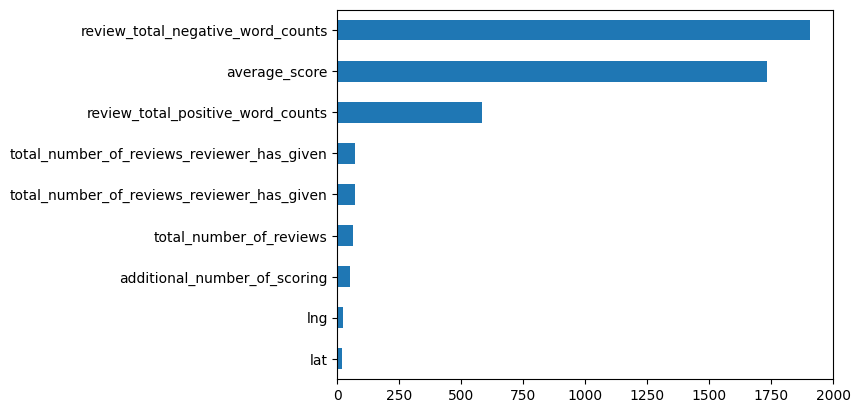

In [219]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [212]:
cols_df = [x for x in hotels.columns if hotels[x].dtype == 'object']

# Удаляем колонки с типом 'object'
hotels1 = hotels.drop(columns=cols_df)
hotels1= hotels1.drop(columns = 'review_date')

In [213]:
hotels1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int32  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

In [217]:
hotels1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int32  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

## Обучение модели ##

In [214]:
X = hotels1.drop(['reviewer_score'], axis = 1)  
y = hotels1['reviewer_score']  
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [215]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [216]:

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12535642323933988


Можно вывести самые важные признаки модели

<Axes: >

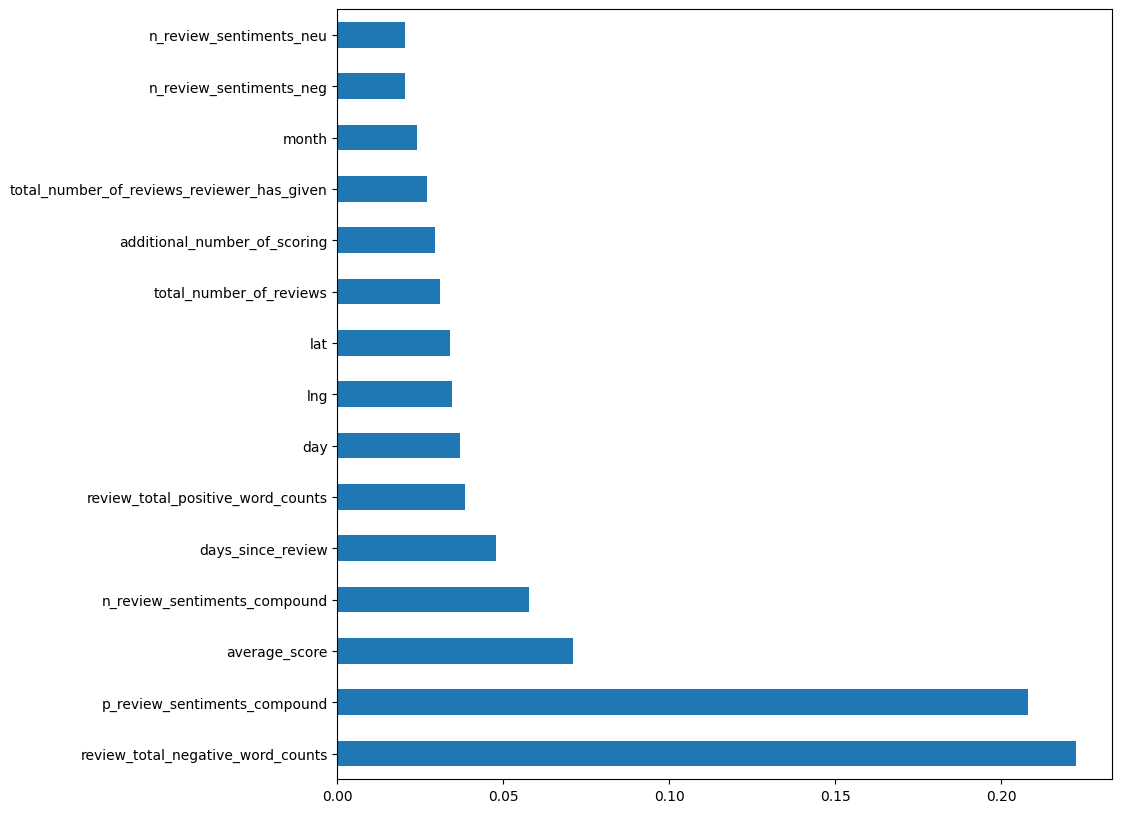

In [221]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [223]:
li = hotels1.columns.to_list()
print(li)

['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'days_since_review', 'lat', 'lng', 'nights', 'year', 'month', 'day', 'hotel_country_Austria', 'hotel_country_France', 'hotel_country_Italy', 'hotel_country_Netherlands', 'hotel_country_Spain', 'hotel_country_United Kingdom', 'nationality_grouped_0', 'nationality_grouped_1', 'nationality_grouped_2', 'nationality_grouped_3', 'n_review_sentiments_neg', 'n_review_sentiments_neu', 'n_review_sentiments_pos', 'n_review_sentiments_compound', 'p_review_sentiments_neg', 'p_review_sentiments_neu', 'p_review_sentiments_pos', 'p_review_sentiments_compound']


In [226]:
hotels2 = hotels1[['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'reviewer_score','total_number_of_reviews_reviewer_has_given','days_since_review', 'lat', 'lng', 'n_review_sentiments_neg','day', 'month','n_review_sentiments_neu', 'n_review_sentiments_pos', 'n_review_sentiments_compound', 'p_review_sentiments_compound']]

In [227]:
X = hotels2.drop(['reviewer_score'], axis = 1)  
y = hotels2['reviewer_score']  
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [228]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [229]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12581546589743975


Значение мап увеличилось несущественно. Я думаю, смело можно брать вторую модель в целях экономии времени и оптимизации, потому что признаков в два раза меньше, а результат практически такой же. 